<a href="https://colab.research.google.com/github/Plogeur/HAI923/blob/main/Notebook_Optimisation%26tensorboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1> Notebook : Optimisation des hyperparametre et visualisation avec tensorboard </H1>

Bienvenue dans ce notebook dédié à l'optimisation des hyperparamètres avec Keras Tuner et à la visualisation des résultats avec TensorBoard. En tant que data scientist, vous savez déjà à quel point le choix judicieux des hyperparamètres peut avoir un impact significatif sur les performances de votre modèle d'apprentissage automatique. Cependant, la recherche manuelle d'hyperparamètres optimaux peut être fastidieuse et coûteuse en temps.

Dans ce notebook, nous allons explorer deux outils essentiels pour vous aider à résoudre ce défi de manière efficace et systématique. Tout d'abord, nous utiliserons Keras Tuner, une bibliothèque puissante pour l'optimisation des hyperparamètres, qui nous permettra d'automatiser la recherche des valeurs optimales pour des hyperparamètres tels que le taux d'apprentissage, le nombre de couches, les fonctions d'activation, etc. Keras Tuner nous aidera à trouver rapidement les configurations les plus performantes pour nos modèles, en nous épargnant des heures de réglages manuels.

Ensuite, nous explorerons TensorBoard, un outil de visualisation intégré à TensorFlow, qui nous permettra de suivre l'évolution de l'apprentissage de notre modèle, d'analyser ses performances et de visualiser graphiquement les résultats. Avec TensorBoard, nous pourrons facilement identifier les tendances, les problèmes potentiels et les améliorations possibles de nos modèles, ce qui est essentiel pour prendre des décisions éclairées en matière d'optimisation.

*Note à moi-même : ça va pas trop ce voir si j'ai fait un copier coller d'un autre notebook ? si ? nooon ca passseeeeeeeeee*

# Installation

In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import seaborn as sns
import random
import shutil
import keras
import pandas as pd
import cv2
import matplotlib.cm as cm
import tensorflow as tf
from keras import metrics
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.saving import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax, Adadelta, Adagrad, SGD
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Dropout, Dense, GlobalAveragePooling2D, Flatten, Rescaling, Conv2D, BatchNormalization, MaxPooling2D
import matplotlib.pyplot as plt
import pathlib
import sys
import keras_tuner

In [ ]:
# GLOBAL VARIABLE
IMG_SIZE = 128
BATCH_SIZE = 4
CHANEL = 3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, CHANEL)
N_KFOLDS = 10
STOPPING_PATIENCE = 50
REDUCTION_PATIENCE = 10
EPOCHS = 500
VERBOSE = 1
COLUMNS = 25
SEED = 123
NUMBERCLASS = 1 # or 3
PATH_DIR = "/content/gdrive/MyDrive/Colab_Notebooks/HAI923/Tiger-Fox-Elephant/"

# SET SEED
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.experimental.enable_op_determinism()

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# CALLBACKS
def callbacks(modelName) :
  EARLY_STOPPING = \
          EarlyStopping(
              monitor='val_loss',
              patience=STOPPING_PATIENCE,
              verbose=VERBOSE,
              mode='auto')

  LR_REDUCTION = \
          ReduceLROnPlateau(
              monitor='val_accuracy',
              patience=REDUCTION_PATIENCE,
              verbose=VERBOSE,
              factor=0.2,
              min_lr=0.000001)

  CHECKPOINT = ModelCheckpoint(f"{modelName}.h5", monitor='val_accuracy', verbose=VERBOSE,
      save_best_only=True, mode='auto', save_freq="epoch")

  CALLBACKS = [EARLY_STOPPING, LR_REDUCTION, CHECKPOINT]
  return CALLBACKS

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      #tf.keras.metrics.Precision(name='precision'),
      #tf.keras.metrics.Recall(name='recall'),
      #tf.keras.metrics.F1Score(threshold=0.5, average='macro', name='f1_score')
      ]

def tensorboardCallback(ModelName) :
  # Create a directory to store TensorBoard logs
  log_dir = f"logs/fit/{ModelName}"  # Replace ModelName with your desired name

  # Create a TensorBoard callback
  tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
  return tensorboard_callback

from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/MyDrive/Colab_Notebooks/HAI923/
path = %pwd

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-5c6655f309cf>", line 71, in <cell line: 71>
    get_ipython().run_line_magic('cd', '/content/gdrive/MyDrive/Colab_Notebooks/HAI923/')
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handli

In [ ]:
def create_rgb(my_path, my_classes) :
  X,y=create_X_y(my_path, my_classes)
  print("Les classes : ", my_classes)
  print("Nombres de données : ", X.shape[0])
  print ("Résolution des images : ", X[0].shape)
  X=X.astype('float')
  X=X/255.0
  return X,y

def create_training_data(path_data, list_classes):
  training_data=[]
  for classes in list_classes:
    path=os.path.join(path_data, classes)
    class_num=list_classes.index(classes)
    for img in os.listdir(path):
      try :
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass
  return training_data

def create_X_y (path_data, list_classes):
      training_data=create_training_data(path_data, list_classes)
      random.shuffle(training_data)
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)
      #y=to_categorical(y) #onehot
      y=np.array(y)

      return X,y

In [ ]:
my_path="Tiger-Fox-Elephant/"
my_classes=['tiger','elephant']
X, y = create_rgb(my_path, my_classes)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3) # .15 pour kfold et .3 pour normal
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)
print(f"Taille de X_train : {len(X_train)}, Taille de X_val : {len(X_val)}, Taille de X_test : {len(X_test)}")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-79d0726fd544>", line 3, in <cell line: 3>
    X, y = create_rgb(my_path, my_classes)
  File "<ipython-input-19-1dea4ac800d6>", line 2, in create_rgb
    X,y=create_X_y(my_path, my_classes)
  File "<ipython-input-19-1dea4ac800d6>", line 25, in create_X_y
    training_data=create_training_data(path_data, list_classes)
  File "<ipython-input-19-1dea4ac800d6>", line 15, in create_training_data
    for img in os.listdir(path):
OSError: [Errno 107] Transport endpoint is not connected: 'Tiger-Fox-Elephant/tiger'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError:

# Optimisation

## Keras tuner

What is ‘hp’?

‘hp’ is an object internally passed by tuner to model-building function to help it specify range of hyperparameter values whenever the tuner is called. This will be clarified more as we go through the code details further.

How and where to specify hyperparameter range values?

Three commonly used ways to do so from my experience:

1. hp.Int()

hp.Int() is used to set the range of a hyperparameter whose values are integers, like for ‘number of filters’ in Convolutional Neural Networks and ‘number of units’ in Dense layer/Fully Connected layer.

Example 1: hp_units = hp.Int(‘units_hp’, min_value = 32, max_value = 128, step = 32)

Therefore, number of dense units in a layer which will be tried by Keras Tuner will be 32, 64, 96 and 128

Example 2: hp_filters = hp.Int(‘filters_hp’, min_value = 32, max_value = 64, step = 32)

Therefore, filters = 32 and filters = 64 will be tried during hyperparameter tuning

2. hp.Float()

hp.Floating() is used to set the range of a hyperparameter whose values are decimal in nature, for example ‘dropout’ and ‘learning_rate’.

Example: hp.Float(‘dropout’, 0, 0.5, step=0.1)

3. hp.Choice()

hp.Choice() offers us way to provide specific values (integers or decimal) and functions to be used for hyperparameter tuning.

Example: hp.Choice(‘learning_rate’, values = [1e-2, 1e-3, 1e-4])

Example: hp.Choice(‘pooling’ , [‘avg’, ‘max’])

All other information are available here : https://keras.io/api/keras_tuner/hyperparameters/

An optimizer is an algorithm or a method that adjusts the model's parameters during the training process to minimize the loss function. The primary goal of an optimizer is to find the set of model parameters that result in the best possible model performance, usually by reducing the error between the model's predictions and the actual target values.

Optimizers play a crucial role in the training of CNNs because they control how the model learns from the training data. CNNs are typically trained using a technique called gradient descent, where the model's parameters are updated in the direction that minimizes the loss function. The optimizer determines how big these updates should be and in which direction they should be applied.

Some common optimizers used in training CNNs and other deep learning models include:

- Stochastic Gradient Descent (SGD): This is the basic form of gradient descent, where the model's parameters are updated based on the gradient of the loss function with respect to each parameter. SGD can be slow to converge but is often used as a baseline optimizer.

- Adam: Adam (short for Adaptive Moment Estimation) is a popular optimizer that adapts the learning rates for each parameter during training. It combines the advantages of both the Adagrad and RMSprop optimizers, making it well-suited for a wide range of tasks.

- RMSprop: Root Mean Square Propagation (RMSprop) is an optimizer that adjusts the learning rates for each parameter based on the magnitude of their gradients. It can help prevent the learning rates from becoming too large and causing training instability.

- Adagrad: Adagrad is an optimizer that adapts the learning rates for each parameter based on the historical gradient information. It is useful for sparse data but may have issues with aggressive learning rate decay.

- Adadelta: Adadelta is an extension of Adagrad that aims to address some of its limitations, particularly with respect to the learning rate scheduling.

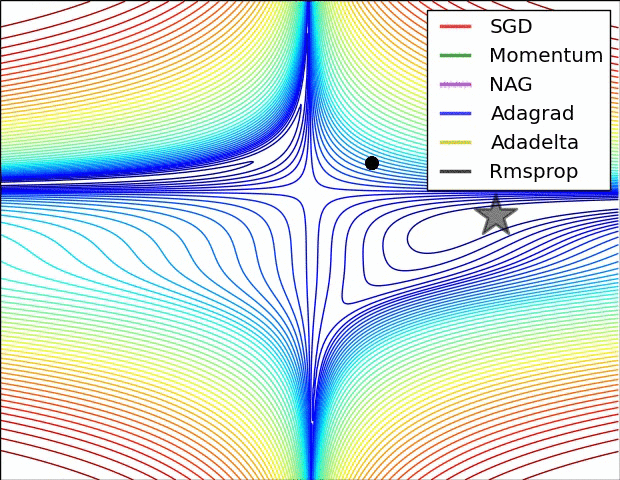

In [ ]:
def build_model(hp):

  model = Sequential()

  # ---- Conv / Pool N°1
  model.add(Conv2D(filters=hp.Int("filter_units_1", min_value=64,
		max_value=256, step=64), kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=hp.Int("filter_units_2", min_value=64,
		max_value=256, step=64), kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  # Flattening : passage de matrices 3D vers un vecteur 1D
  model.add(Flatten())
  model.add(Dense(hp.Int("dense_units_1", min_value=64,
		max_value=512, step=64), activation='relu'))
  model.add(Dropout(hp.Float("dropout_units_1", min_value=0,
		max_value=0.4, step=0.1)))
  model.add(Dense(hp.Int("dense_units_2", min_value=32,
		max_value=256, step=32), activation='relu'))
  model.add(Dropout(hp.Float("dropout_units_2", min_value=0,
		max_value=0.4, step=0.1)))

  # Couche de sortie : classification => softmax sur le nombre de classe / sigmoid pour classe = 2
  model.add(Dense(units=1, activation='sigmoid'))

  # compilation du model de classification
  lr = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
  # Select optimizer
  opt=hp.Choice('optimizer', values=['adam','adamax','adagrad','adadelta','SGD'])

  # Conditional for each optimizer
  if opt == 'adam':
    opt=Adam(learning_rate=lr)
  elif opt == 'adamax':
    opt=Adamax(learning_rate=lr)
  elif opt == 'adagrad':
    opt=Adagrad(learning_rate=lr)
  elif opt == 'adadelta':
    opt=SGD(learning_rate=lr)
  elif opt == 'SGD':
    opt=SGD(learning_rate=lr)
  else :
    raise

  model.compile(optimizer=opt, loss='binary_crossentropy', metrics='accuracy')

  return model

max_trail:

This number is the number of combinations of hyperparameters to be tried/executed to find the best among them. Why do we need this you ask? If the hyperparameter space is too large (thousands/million number of combinations may be possible with given ranges of hyperparameters), the tuner will run forever!!!!. To avoid this we can specify the number of combinations to be tried by the tuner to give us the best set of hyperparameters.

Example: We have its value as 4, so no matter how many combinations are possible, it will only choose 4 combinations out of all and gives us the best hyperparameter among this 4 combinations.

Note: Some tuners may rerun the same combination of hyperparameters again. Example: If one of the combinations is repeated, then total number of times trail here is 4, but now number of combinations tried are 3. Hence the parameter name ‘max_trials’ instead of ‘max_combinations’.

execution_per_trail:

It tells the tuner the number of times a single combination has to be executed in order to measure the combinations performance on the objective. Many times Neural Network models does not given exact same results but closer, when rerun, due to approximations and many other reasons. In order to avoid those pitfalls this parameter is useful.

Bayesian Optimization tuner Concept:

This techniques addresses a common problem in RandomSearch and Hyperband. Problem: All the hyperparameter combinations are chosen randomly. Choosing hyperparameters randomly helps to explore the hyperparameter space but does not guarantee absolute optimal hyperparameters. Solution provided by BayesianOptimization tuner: Instead of all combinations being random, it chooses first few randomly, then based on the performance on these hyperparameters it chooses the next best possible hyperparameters. Hence it takes into account the history of the hyperparameters which were tried. The iterations of choosing next set of hyperparameters based on history and evaluating performance continues till the tuner reaches optimal hyperparameters or exhausts maximum number of allowed trails. Maximum trials are set using parameter ‘max_trails’.

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    build_model,
    max_trials=10,
    overwrite=True,
    objective="val_accuracy",
    directory="/tmp/tb",
)

model.fit() is replaced by tuner.search(). The parameters provided to the tuner.search() are exactly same to the parameters provided to model.fit(). ‘epochs’ here is the number of epochs run on EACH model/trail/combination by default unless the tuner algorithm changes it. Example: Hyperband used different number of epochs at different stages for evaluating the model.

In [ ]:
tuner.search(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,
    callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
)

Trial 10 Complete [00h 04m 08s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.9666666388511658
Total elapsed time: 02h 43m 20s


Best hyperparameters and best models can be extracted from tuner when tuner.search() execution is complete



In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'filter_units_1': 256, 'filter_units_2': 192, 'dense_units_1': 320, 'dropout_units_1': 0.2, 'dense_units_2': 32, 'dropout_units_2': 0.4, 'learning_rate': 0.001, 'optimizer': 'SGD'}


Le tableau de bord HParams peut maintenant être ouvert. Démarrez TensorBoard et cliquez sur "HParams" en haut.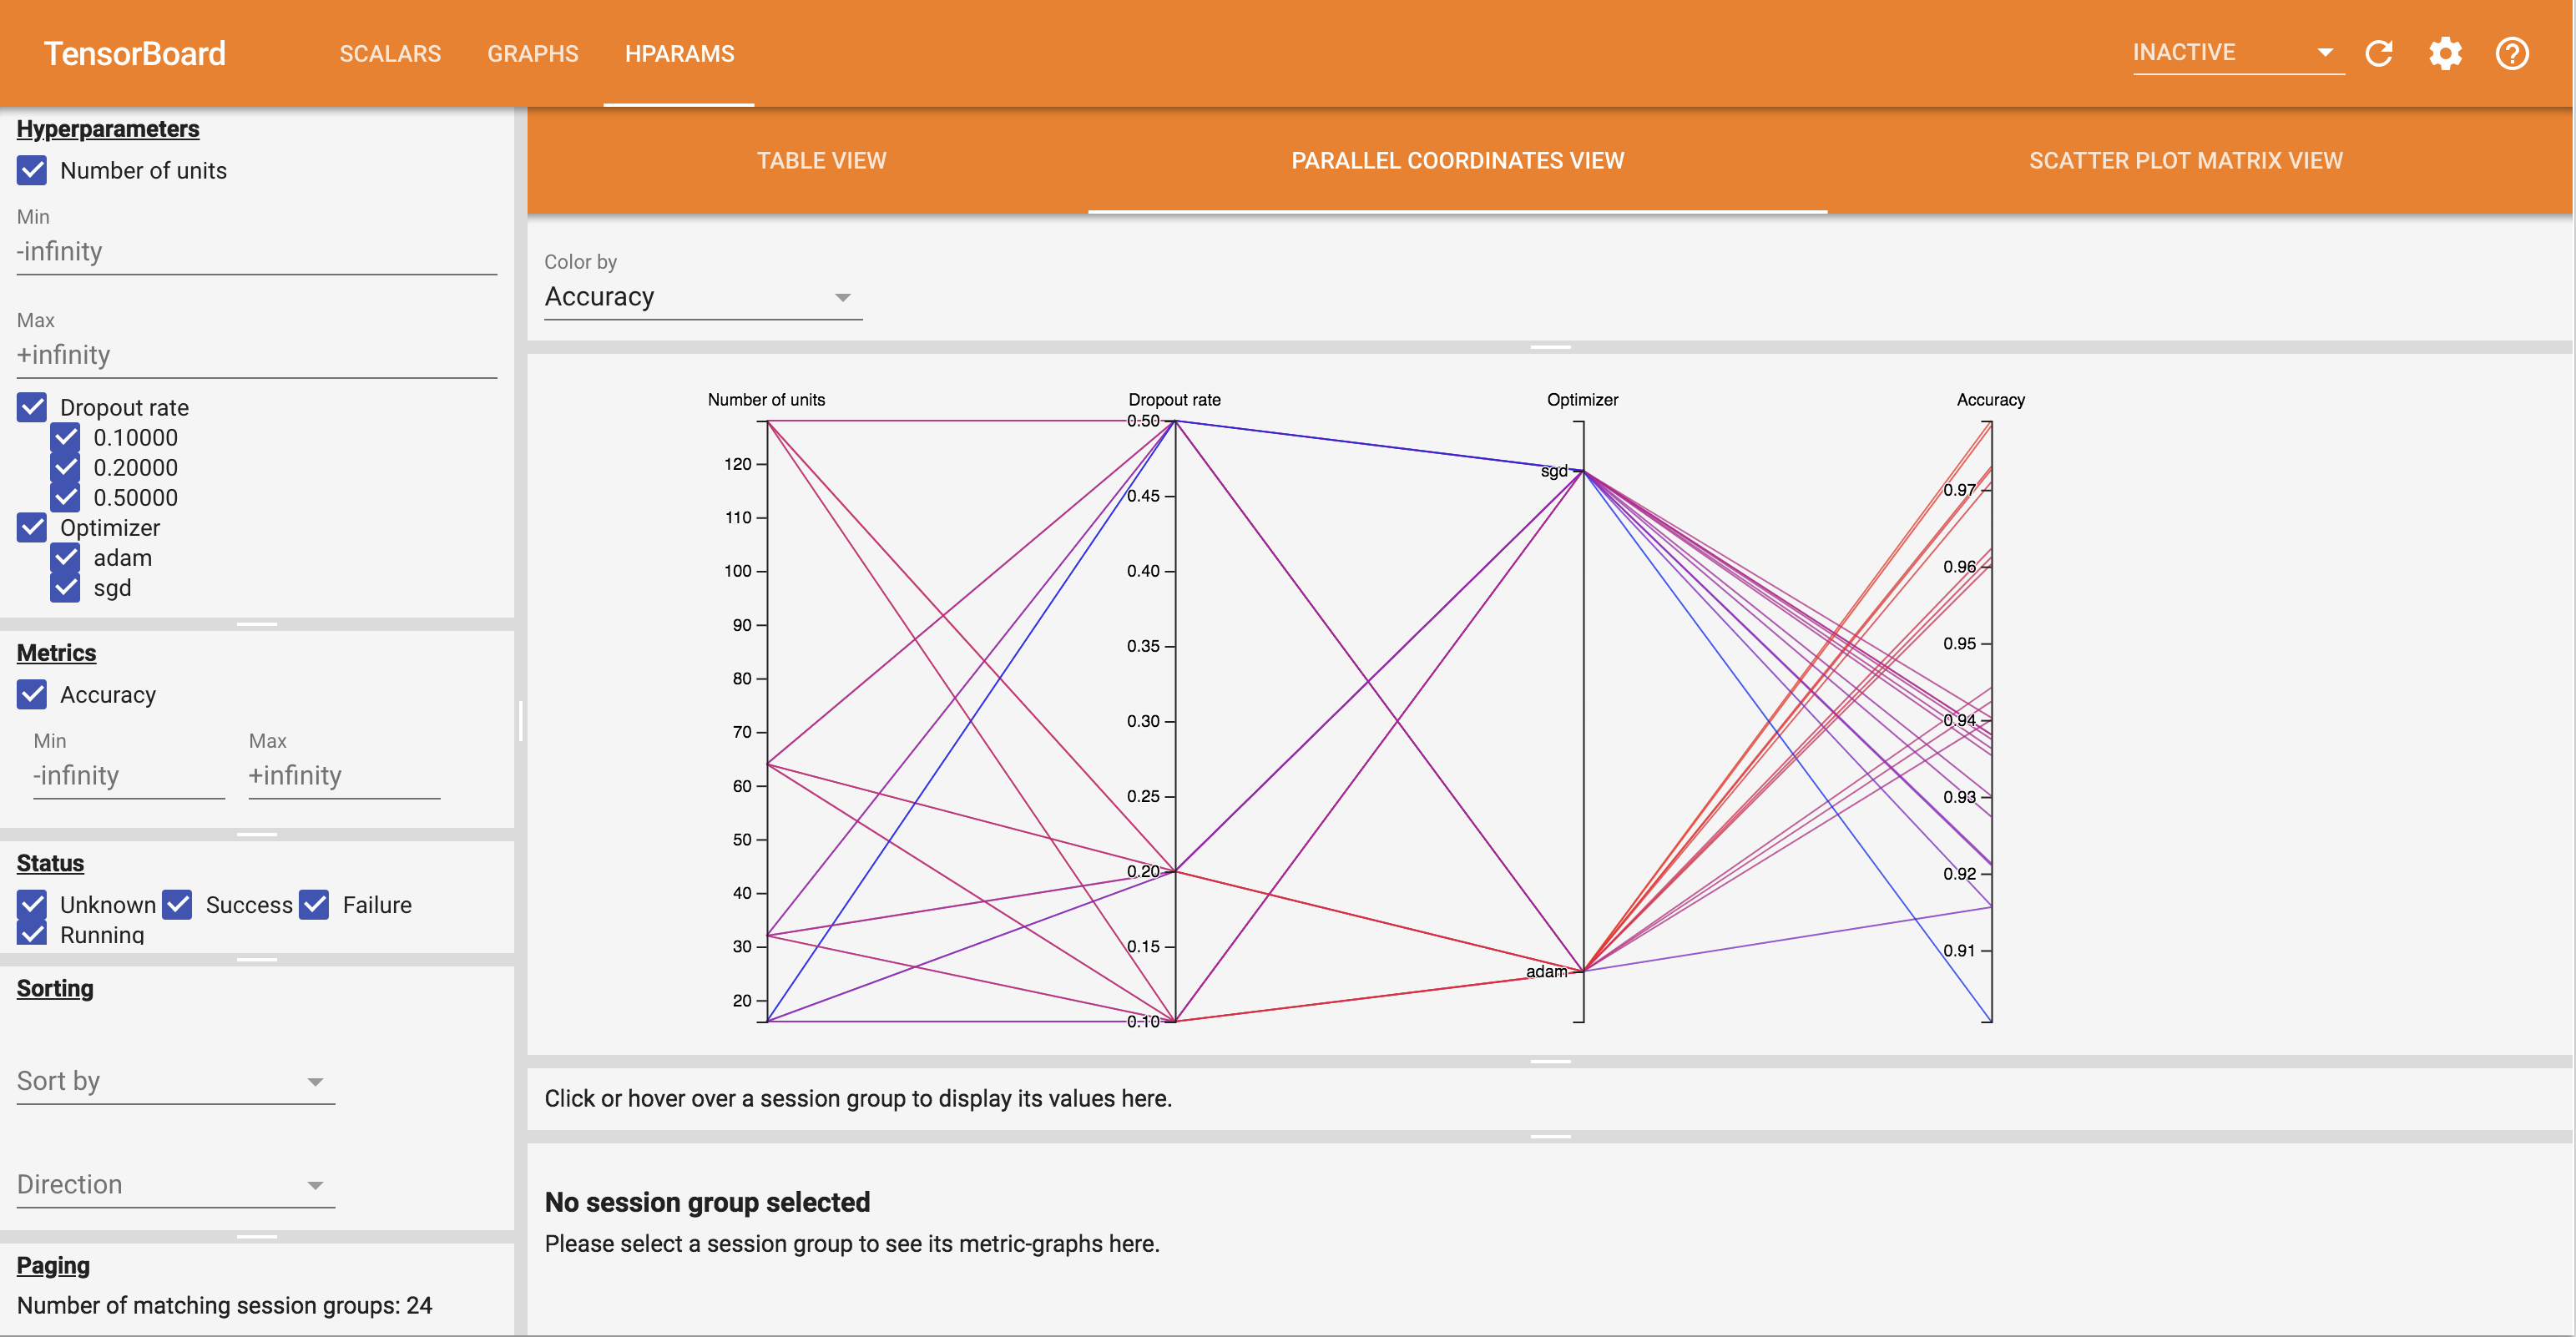

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs

## Ray tune

In [ ]:
!pip install -U "ray[air]"
!pip install tensorboardX

In [ ]:
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search import ConcurrencyLimiter
from hyperopt import hp
import ray
from ray import train, tune
from tune.schedulers import ASHAScheduler
from ray.air.integrations.keras import ReportCheckpointCallback

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ConvNeXtLarge

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-038046481f13>", line 1, in <cell line: 1>
    from ray.tune.schedulers import AsyncHyperBandScheduler
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1002, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 945, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1439, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1408, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1366, in _path_importer_cache
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactivesh

In [ ]:
ray.shutdown()

def create_model(config):

    #base_model = args.model_name(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Finetune the last conv layer of the model
    base_model.layers[-1] = True

    # Add custom layers on top of the base model
    x = base_model.output

    if config["flatten"] :
      x = Flatten()(x)

    else :
      x = GlobalAveragePooling2D()(x)
      x = Dropout(config['dropout_rate'])(x)  # Add a dropout layer after the first dense layer

    x = Dense(config['fc1_units_1'], activation=config['activation_1'])(x)
    x = Dropout(config['dropout_rate'])(x)  # Add a dropout layer after the first dense layer
    x = Dense(config['fc1_units_2'], activation=config['activation_2'])(x)  # Add an additional dense layer
    predictions = Dense(1, activation='sigmoid')(x)  # Single output dense layer

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

def train_model(config):

    batch_size = config["batch_size"]
    epochs = 10

    # Create the model
    model = create_model(config)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=config['lr']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, Y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        validation_data=(X_val, Y_val),
        callbacks=[ReportCheckpointCallback(metrics={"mean_loss": "val_loss", "mean_accuracy": "val_accuracy"})])

    # Return the validation accuracy as the metric to optimize
    return {'val_accuracy': 0.95}

ray.init()

# Define the hyperparameter search space
space = {
    "batch_size": tune.choice([8, 16, 32, 64]),
    "flatten" : tune.choice([True, False]),
    "dropout_rate": tune.choice([0.1, 0.2, 0.3, 0.4, 0.5]),
    "fc1_units_1": tune.choice([32, 64, 128, 256, 512, 1024]),
    "fc1_units_2": tune.choice([32, 64, 128, 256, 512]),
    "activation_1": tune.choice(["relu", "elu", "tanh"]),
    "activation_2": tune.choice(["relu", "elu", "tanh"]),
    "lr": tune.uniform(0.0001, 0.001),
}

# Configure the hyperparameter search
scheduler = ASHAScheduler(metric="mean_accuracy", mode="max", max_t=10, grace_period=1)
search_alg = HyperOptSearch(space, metric='mean_accuracy', mode='max')

tuner = tune.Tuner(
    train_model,
    search_alg=search_alg,
    scheduler=scheduler,
    num_samples=25,
    resources_per_trial={'cpu': 2, 'gpu': 1})

results = tuner.fit()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-3c5bca01ee61>", line 1, in <cell line: 1>
    ray.shutdown()
NameError: name 'ray' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py",

In [ ]:
%tensorboard --logdir=~/ray_results/my_experiment

Launching TensorBoard...

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-eb94bf07f05d>", line 1, in <cell line: 1>
    get_ipython().run_line_magic('tensorboard', '--logdir=~/ray_results/my_experiment')
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/notebook.py", line 117, in _start_magic
    return start(line)
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/notebook.py", line 152, in start
    start_result = manager.start(parsed_args)
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/manager.py", line 415, in start
    working_directory=os.getcwd(),
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception

In [ ]:
%export TMPDIR=/tmp/$USER; mkdir -p $TMPDIR; tensorboard --logdir=~/ray_results